In [1]:
import numpy as np
from scipy import ndimage

import matplotlib.pyplot as plt

import skimage

from tqdm import tqdm, trange

In [2]:
from geo_files import AscFile

## Util functions

In [3]:
def coords_to_field(coords, values, field_shape):
    field = np.zeros(shape=field_shape)
    m = values.shape[0]
    for k in range(m):
        y, x = coords[:, k]
        field[y, x] = values[k]
    return field

#def weak_local_minima(image, extent, mask):
def weak_local_minima(image, mask, extent=1):
    minima = np.zeros_like(image)
    iy, ix = image.shape
    for y in range(extent, (iy-extent)):
        for x in range(extent, (ix-extent)):
            mask_val = mask[y, x]
            if np.isnan(mask_val) or mask_val == 0:
                continue
            sub = image[(y-extent):(y+extent+1),(x-extent):(x+extent+1)]
            if (sub >= image[y, x]).all():
                minima[y, x] = 1
    return minima

def weak_local_minima_or_flat(image, mask, extent=1):
    minima = np.zeros_like(image)
    iy, ix = image.shape
    for y in range(extent, (iy-extent)):
        for x in range(extent, (ix-extent)):
            mask_val = mask[y, x]
            if np.isnan(mask_val) or mask_val == 0:
                continue
            sub = image[(y-extent):(y+extent+1),(x-extent):(x+extent+1)]
            if (sub >= image[y, x]).all():
                minima[y, x] = 1
            else:
                flat_nbhd = (sub == image[y, x])
                flat_nbhd[extent, extent] = False
                minima[y, x] = flat_nbhd.any()
    return minima

def zero_to_nan(image, val=0):
    im = np.copy(image).astype(float)
    im[im == val] = np.nan
    return im

def nonzero_min(image, mask):
    min_area = image * mask
    min_area[min_area == 0] = min_area.max()*2
    return np.nanmin(min_area)

## Data

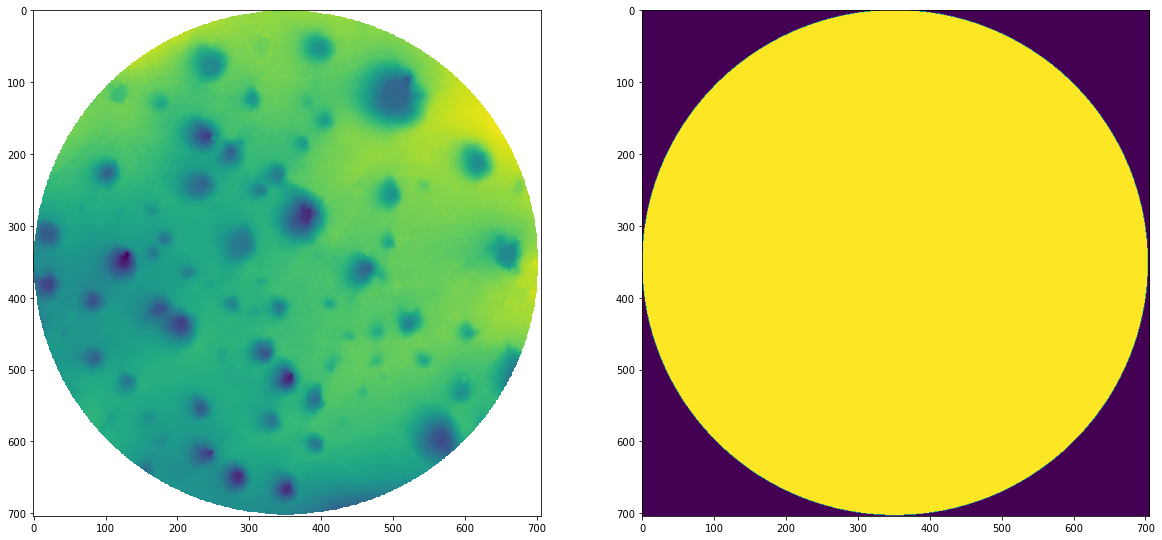

In [11]:
## Loading
plot_data = True

file_num = 3

mount_point = "/home/vcwork/Workspace/IJS/team_oe6"
dataset_location = "/ParallelLab_Data/datasets/vrtace_testni_primeri"
base_path = mount_point + dataset_location
base_path = "/home/vcwork/Workspace/IJS/sinkhole-new/proto/IJS_obodi"
dmv = AscFile(base_path + f'/obm{file_num}/ASCII{file_num}/dmv{file_num}.txt')

terrain_raw = dmv.data.astype(float)
terrain_raw[terrain_raw < 0] = np.nan
data_mask_raw = (1 - np.isnan(terrain_raw)).astype(int)
data_mask_partial_raw = zero_to_nan(data_mask_raw)

if plot_data:
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    axs[0].imshow(terrain_raw)
    axs[1].imshow(data_mask_raw)

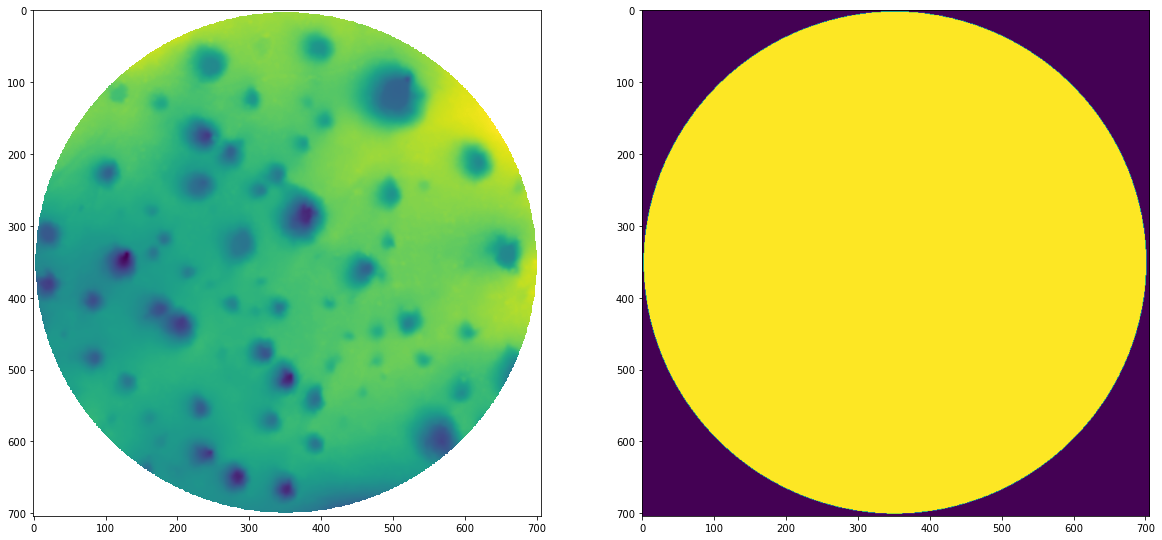

In [12]:
# Smoothing
rad = 5
smoothing_kernel = np.ones(shape=(rad, rad))/(rad**2)
terrain = ndimage.convolve(terrain_raw, smoothing_kernel, mode='constant', cval=np.nan)
data_mask_partial = ndimage.convolve(data_mask_partial_raw, smoothing_kernel, mode='constant', cval=np.nan)
data_mask = (1 - np.isnan(data_mask_partial)).astype(float)
if plot_data:
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    axs[0].imshow(terrain)
    axs[1].imshow(data_mask)

## Segmentation

In [ ]:
def get_labeled_minima(image, data_mask):
    minima_mask = weak_local_minima_or_flat(image, data_mask)
    minima_labels, number_of_minima = skimage.morphology.label(minima_mask, return_num=True)
    return minima_labels, number_of_minima

def watershed_reduce(image, data_mask, minima_labels, number_of_minima, tol=1, prog=True):
    watershed_labels = skimage.segmentation.watershed(image, minima_labels, mask = data_mask)
    minima = range(number_of_minima)
    if prog:
        minima = tqdm(minima, total=number_of_minima)
    s0 = 1
    sinkhole_labels = np.zeros_like(image)
    image_filled = np.copy(image)
    for m in minima:
        s = m+1
        local_indicator = (watershed_labels == s).astype(int)
        pour_height = nonzero_min(image, (ndimage.distance_transform_edt(local_indicator) < 1.3) * local_indicator)
        bottom_height = nonzero_min(image, local_indicator)
        sinkhole_indicator = ((image <= pour_height) * local_indicator).astype(int)
        if pour_height >= bottom_height + tol:
            sinkhole_labels += sinkhole_indicator*s0
            s0 += 1
        #image_filled = image_filled * skimage.util.invert(sinkhole_indicator) + sinkhole_indicator * pour_height
        image_filled[sinkhole_indicator == 1] = sinkhole_indicator[sinkhole_indicator ==1] * pour_height
    return sinkhole_labels, s0, image_filled

def watershed_step(image, data_mask, steps=1, tol=1, prog=True):
    minima_labels, number_of_minima = get_labeled_minima(image, data_mask)
    sinkhole_labels, number_of_sinkholes, filled_image = watershed_reduce(image, data_mask, minima_labels, number_of_minima, tol=tol, prog=prog)
    if steps < 2:
        return sinkhole_labels, number_of_sinkholes, filled_image
    else:
        return watershed_step(filled_image, data_mask, steps=(steps-1), tol=tol, prog=prog)

def watershed_step_full(image, data_mask, steps, tol=1, prog=True):
    iy, ix = image.shape
    sinkhole_labels_all = np.zeros(shape=(iy, ix, steps))
    number_of_sinkholes_all = [0] * steps
    filled_image_all = np.zeros(shape=(iy, ix, steps))
    
    filled_image = image
    for step in range(steps):
        minima_labels, number_of_minima = get_labeled_minima(filled_image, data_mask)
        sinkhole_labels, number_of_sinkholes, filled_image = watershed_reduce(filled_image, data_mask, minima_labels, number_of_minima, tol=tol, prog=prog)
        sinkhole_labels_all[:, :, step] = sinkhole_labels
        number_of_sinkholes_all[step] = number_of_sinkholes
        filled_image_all[:, :, step] = filled_image
    return sinkhole_labels_all, number_of_sinkholes_all, filled_image_all

In [ ]:
iteration_steps = 5
sinkhole_labels_all, number_of_sinkholes_all, filled_image_all = watershed_step_full(terrain, data_mask, iteration_steps, tol=0)

In [ ]:
fig, ax = plt.subplots(1, iteration_steps, figsize=(30, 30))
for step in range(iteration_steps):
    ax[step].imshow(zero_to_nan(sinkhole_labels_all[:, :, step]))

In [ ]:
plot_steps = [3, 4]
fig, ax = plt.subplots(1, len(plot_steps), figsize=(30, 30))
for k in range(len(plot_steps)):
    step = plot_steps[k]
    ax[k].imshow(zero_to_nan(sinkhole_labels_all[:, :, step]))

# Cumulative sums

In [13]:
def get_labeled_minima(image, data_mask):
    minima_mask = weak_local_minima_or_flat(image, data_mask)
    minima_labels, number_of_minima = skimage.morphology.label(minima_mask, return_num=True)
    return minima_labels, number_of_minima

def mask_inclusion(m1, m2, data_mask):
    comp = ((m1 * m2) == m1).astype(int)
    comp_no_nans = data_mask * comp + (1 - data_mask).astype(int)
    return comp_no_nans.all()

def watershed_reduce_cumulative(image, data_mask, old_labels, old_cumulative_fill, minima_labels, number_of_minima, prog=True):
    watershed_labels = skimage.segmentation.watershed(image, minima_labels, mask = data_mask)
    minima = range(number_of_minima)
    if prog:
        minima = tqdm(minima, total=number_of_minima)
    s0 = 1
    sinkhole_labels = np.zeros_like(image).astype(int)
    image_filled = np.copy(image)
    old_holes_in_new_hole = [0] * number_of_minima
    number_of_old_holes = old_labels.max()
    cumulative_fill = [0] * number_of_minima
    for m in minima:
        old_holes_in_new_hole[m] = []
        s = m+1
        local_indicator = (watershed_labels == s).astype(int)
        pour_height = nonzero_min(image, (ndimage.distance_transform_edt(local_indicator) < 1.3) * local_indicator)
        bottom_height = nonzero_min(image, local_indicator)
        hole_indicator = ((image <= pour_height) * local_indicator).astype(int)
        fill_height = pour_height - bottom_height
        potential_old_holes_in_new_hole = np.unique(hole_indicator * old_labels)
        for potential_hole in potential_old_holes_in_new_hole:
            #if potential_hole > 0 and mask_inclusion(old_labels == potential_hole, hole_indicator, data_mask):
            if potential_hole > 0:
                old_holes_in_new_hole[m].append(potential_hole - 1)
        max_old_fill = 0
        for hole_label in old_holes_in_new_hole[m]:
            max_old_fill = max(max_old_fill, old_cumulative_fill[hole_label])
        cumulative_fill[m] = fill_height + max_old_fill
        image_filled[hole_indicator == 1] = hole_indicator[hole_indicator ==1] * pour_height
        sinkhole_labels += hole_indicator * s
    return sinkhole_labels, number_of_minima, image_filled, cumulative_fill, old_holes_in_new_hole

def watershed_step_full_cumulative(image, data_mask, steps, prog=True):
    iy, ix = image.shape
    sinkhole_labels_all = np.zeros(shape=(iy, ix, steps)).astype(int)
    number_of_sinkholes_all = [0] * steps
    filled_image_all = np.zeros(shape=(iy, ix, steps))
    cumulative_fill_all = [0] * steps
    inclusion_maps = [0] * steps
    
    filled_image = image
    old_labels = np.zeros_like(image).astype(int)
    old_cumulative_fill = []
    
    for step in range(steps):
        minima_labels, number_of_minima = get_labeled_minima(filled_image, data_mask)
        old_labels, number_of_sinkholes, filled_image, old_cumulative_fill, inclusion_map = watershed_reduce_cumulative(filled_image, data_mask, old_labels, old_cumulative_fill, minima_labels, number_of_minima, prog=prog)
        sinkhole_labels_all[:, :, step] = old_labels
        number_of_sinkholes_all[step] = number_of_sinkholes
        filled_image_all[:, :, step] = filled_image
        cumulative_fill_all[step] = old_cumulative_fill
        inclusion_maps[step] = inclusion_map
    return sinkhole_labels_all, number_of_sinkholes_all, filled_image_all, cumulative_fill_all, inclusion_maps

In [14]:
iteration_steps = 10
hole_labels_all, number_of_holes_all, filled_image_all, cumulative_fill_all, inclusion_maps = watershed_step_full_cumulative(terrain, data_mask, iteration_steps)

100%|█████████████████████████████████████████████████████████████████████████████| 577/577 [00:32<00:00, 17.78it/s]


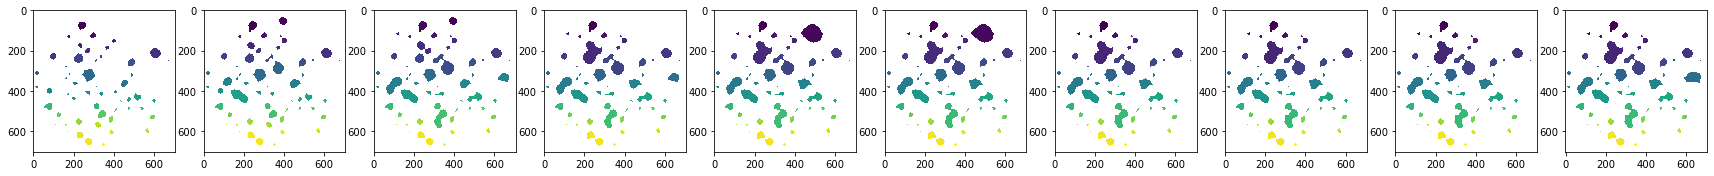

In [15]:
tol = 1
sinkhole_labels_all = np.zeros_like(hole_labels_all)
s0 = 1
for step in range(iteration_steps):
    sinkhole_labels = np.zeros_like(hole_labels_all[:, :, step])
    for hole in range(number_of_holes_all[step]):
        hole_indicator = hole_labels_all[:, :, step] == (hole + 1)
        if cumulative_fill_all[step][hole] >= tol:
            sinkhole_labels += hole_indicator * s0
            s0 += 1
    sinkhole_labels_all[:, :, step] = sinkhole_labels

fig, ax = plt.subplots(1, iteration_steps, figsize=(30, 30))
for step in range(iteration_steps):
    ax[step].imshow(zero_to_nan(sinkhole_labels_all[:, :, step]))

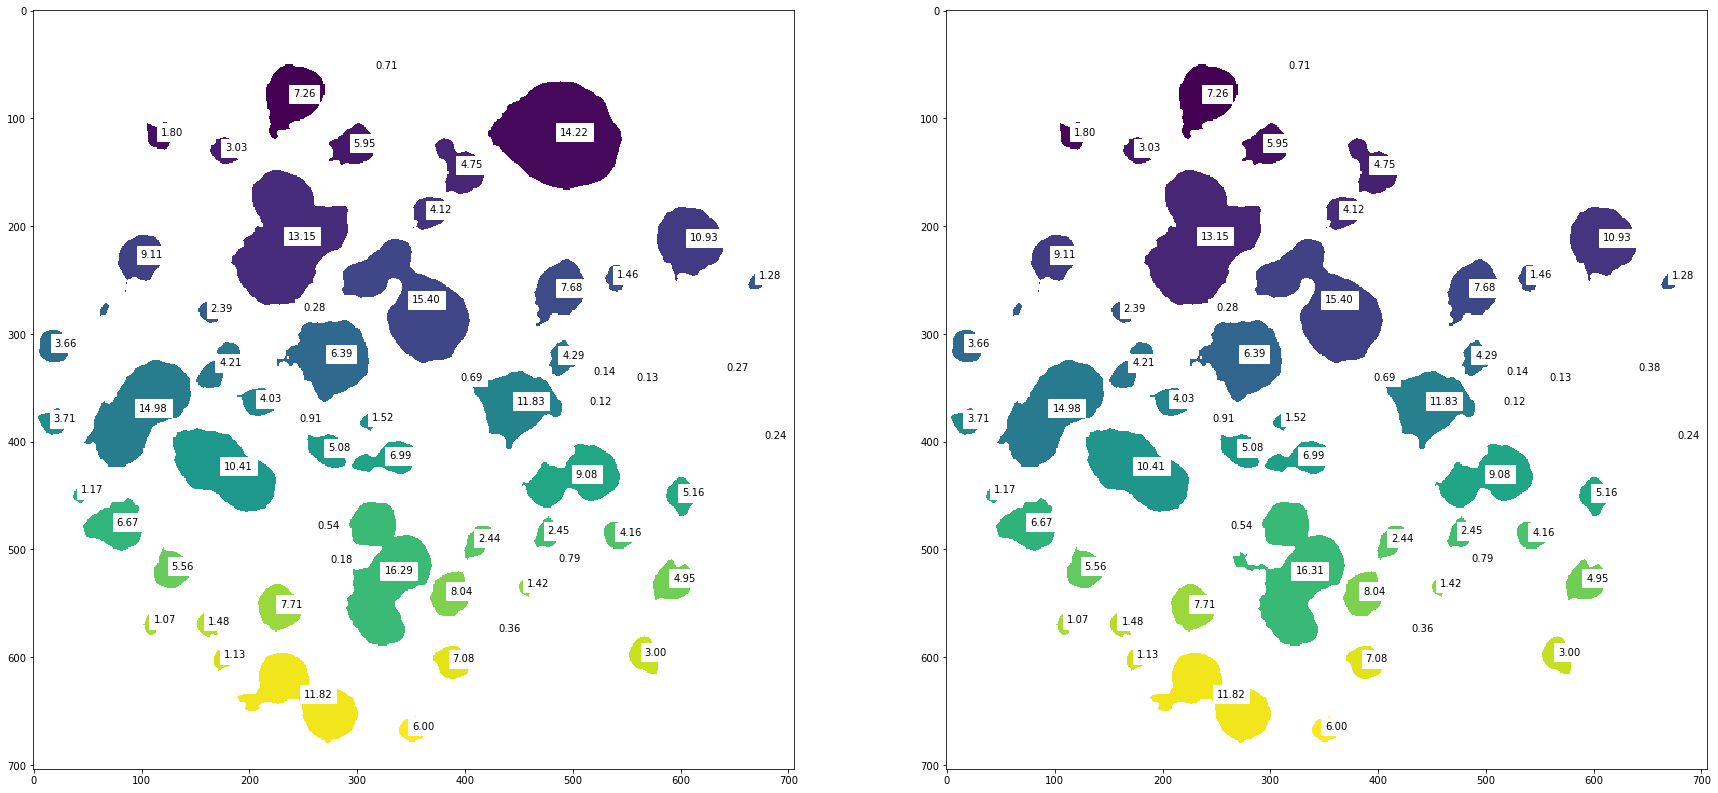

In [17]:
plot_steps = [5, 6]
fig, ax = plt.subplots(1, len(plot_steps), figsize=(30, 30))
for k in range(len(plot_steps)):
    step = plot_steps[k]
    ax[k].imshow(zero_to_nan(sinkhole_labels_all[:, :, step]))
    props = skimage.measure.regionprops(hole_labels_all[:, :, step])
    for hole in range(number_of_holes_all[step]):
        cy, cx = props[hole].centroid
        cumul_fill = cumulative_fill_all[step][hole]
        #if cumul_fill > 1:
        if props[hole].area > 100:
        #if True:
            ax[k].text(cx, cy, "%.2f" % cumul_fill, backgroundcolor='white')
            #ax[k].text(cx, cy, str(hole_labels_all[int(cy), int(cx), step]), backgroundcolor='white')

In [18]:
def xor_mask(m1, m2):
    return (m1 * (1 - m2)) + ((1 - m1) * m2)

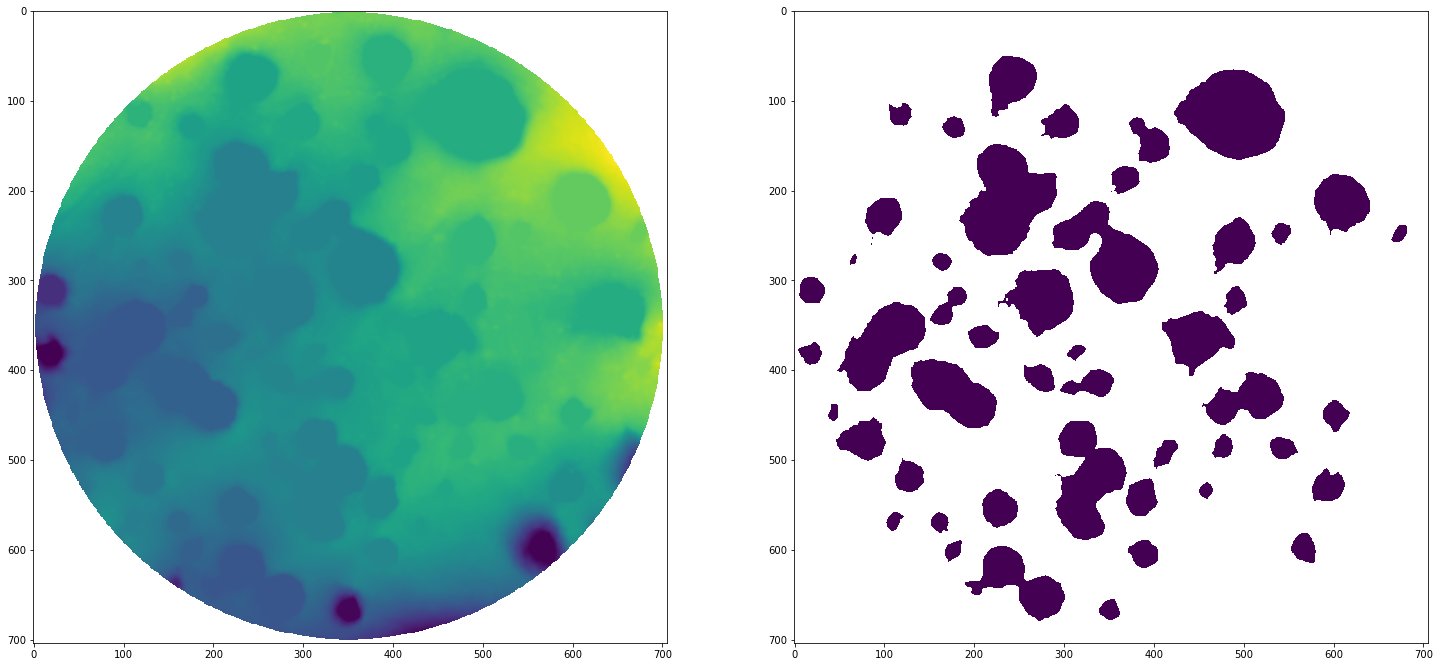

In [26]:
test_filled_0 = filled_image_all[:, :, 5]
test_sinkhole_mask_0 = sinkhole_labels_all[:, :, 5] > 0

fig, ax = plt.subplots(1, 2, figsize = (25, 25))
ax[0].imshow(test_filled_0)
ax[1].imshow(zero_to_nan(test_sinkhole_mask_0))

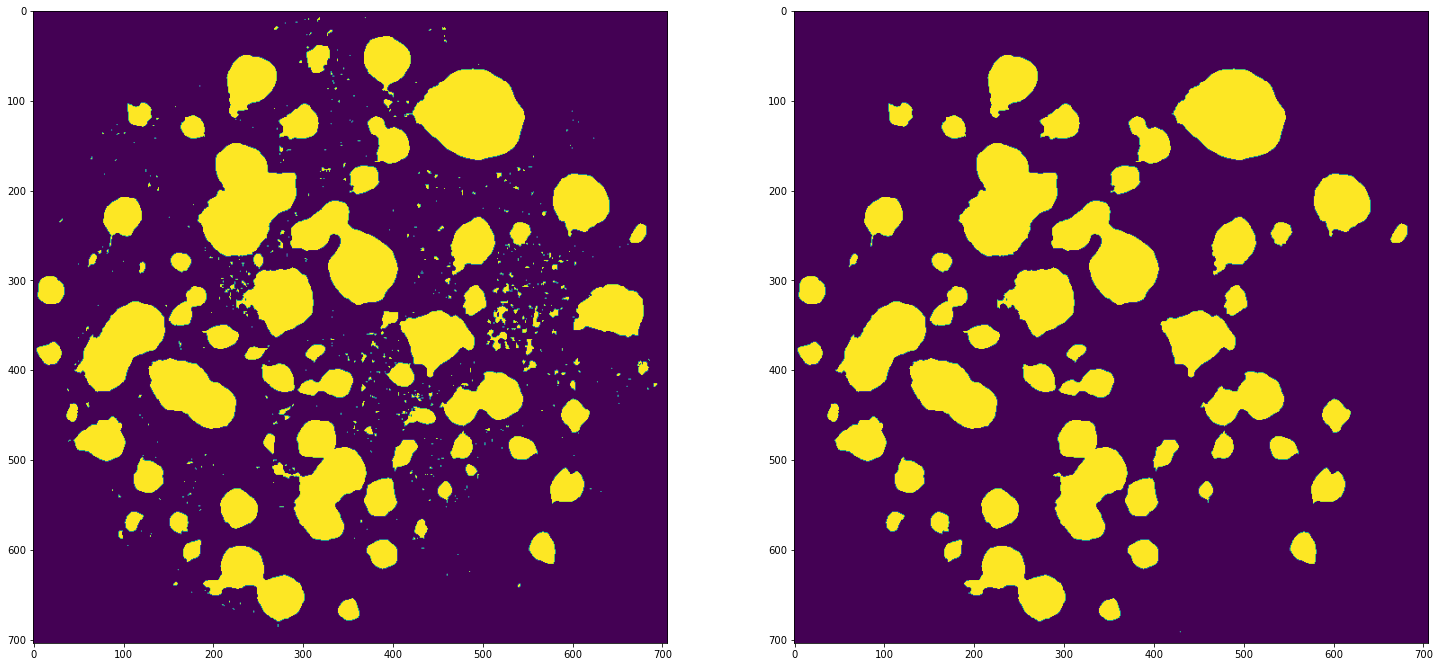

In [27]:
test_mins_after_0 = weak_local_minima_or_flat(test_filled_0, data_mask)

fig, ax = plt.subplots(1, 2, figsize = (25, 25))
ax[0].imshow(test_mins_after_0)
ax[1].imshow(test_sinkhole_mask_0)

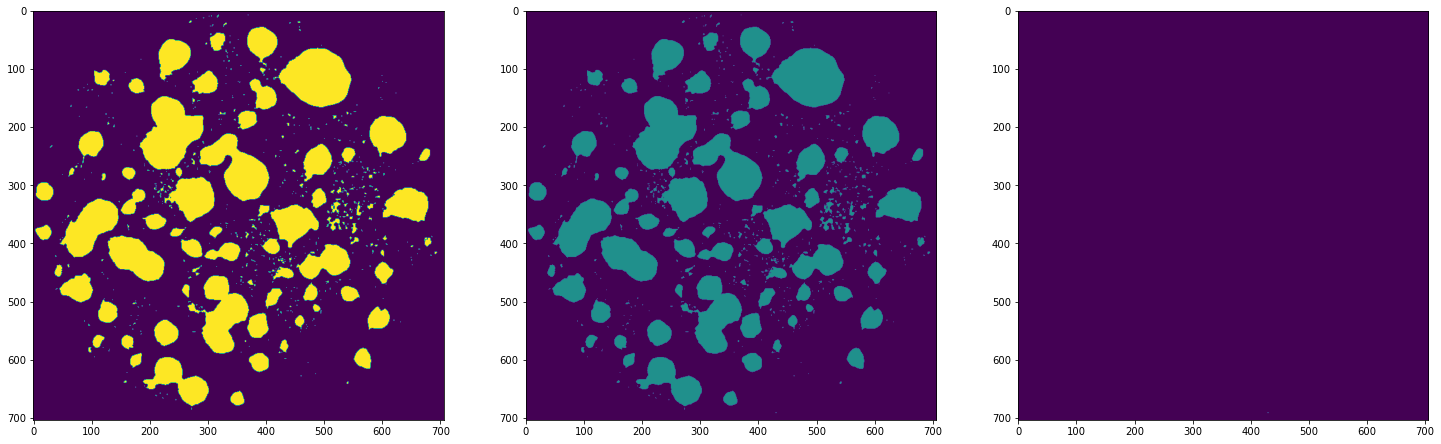

In [29]:
test_problems_0 = test_sinkhole_mask_0 * (1 - test_mins_after_0)

fig, ax = plt.subplots(1, 3, figsize = (25, 25))
ax[0].imshow(test_mins_after_0)
ax[1].imshow(xor_mask(test_sinkhole_mask_0, test_mins_after_0) + test_sinkhole_mask_0)
ax[2].imshow(test_sinkhole_mask_0 * (1 - test_mins_after_0))

In [30]:
from sinkhole_util import get_window

ec_y, ec_x = 691, 429

test_extent = 30
t_filled_w, _ = get_window(test_filled_0, (ec_y, ec_x), test_extent, normalize=False)
t_indicator_w, _ = get_window(test_sinkhole_mask_0, (ec_y, ec_x), test_extent, normalize=False)
t_mins_w, _ = get_window(test_mins_after_0, (ec_y, ec_x), test_extent, normalize=False)

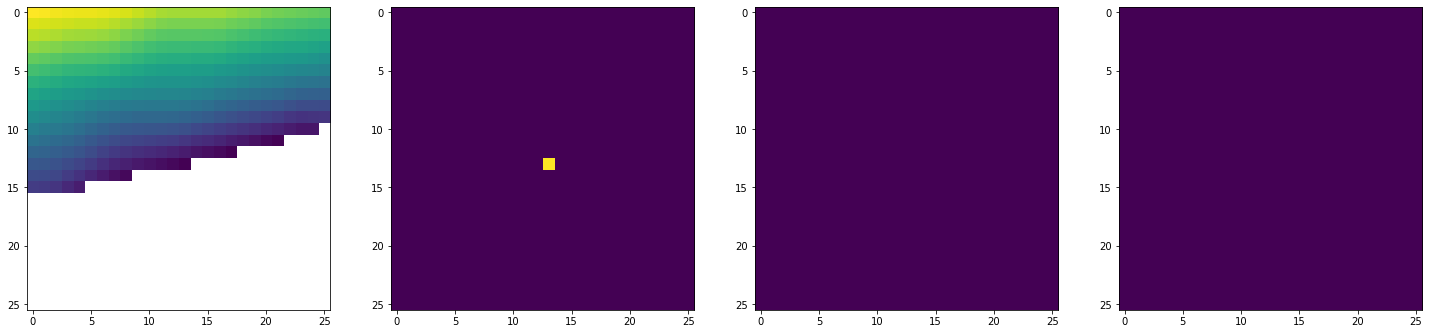

In [31]:
fig, ax = plt.subplots(1, 4, figsize = (25, 25))
ax[0].imshow(t_filled_w)
ax[1].imshow(t_indicator_w)
ax[2].imshow(t_mins_w)
ax[3].imshow(weak_local_minima_or_flat(t_filled_w, np.ones_like(t_filled_w)))

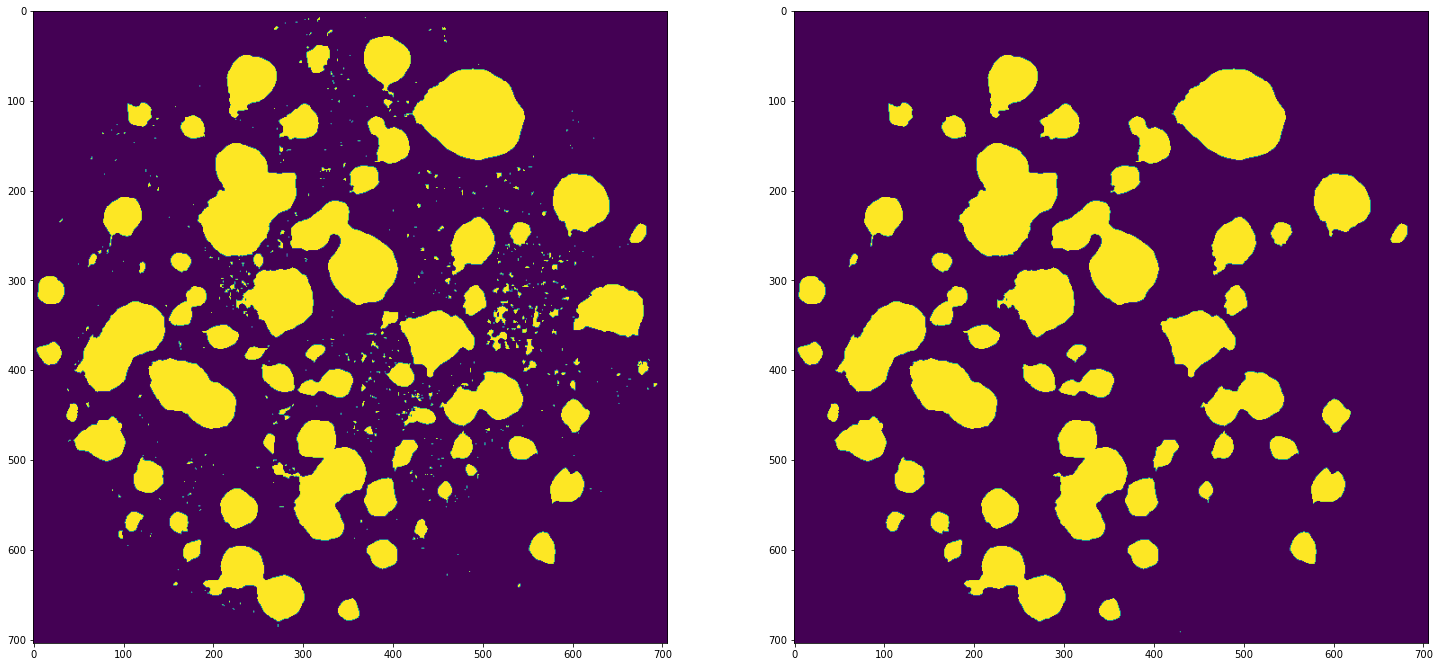

In [32]:
fig, ax = plt.subplots(1, 2, figsize = (25, 25))
ax[0].imshow(test_mins_after_0)
ax[1].imshow(test_sinkhole_mask_0)

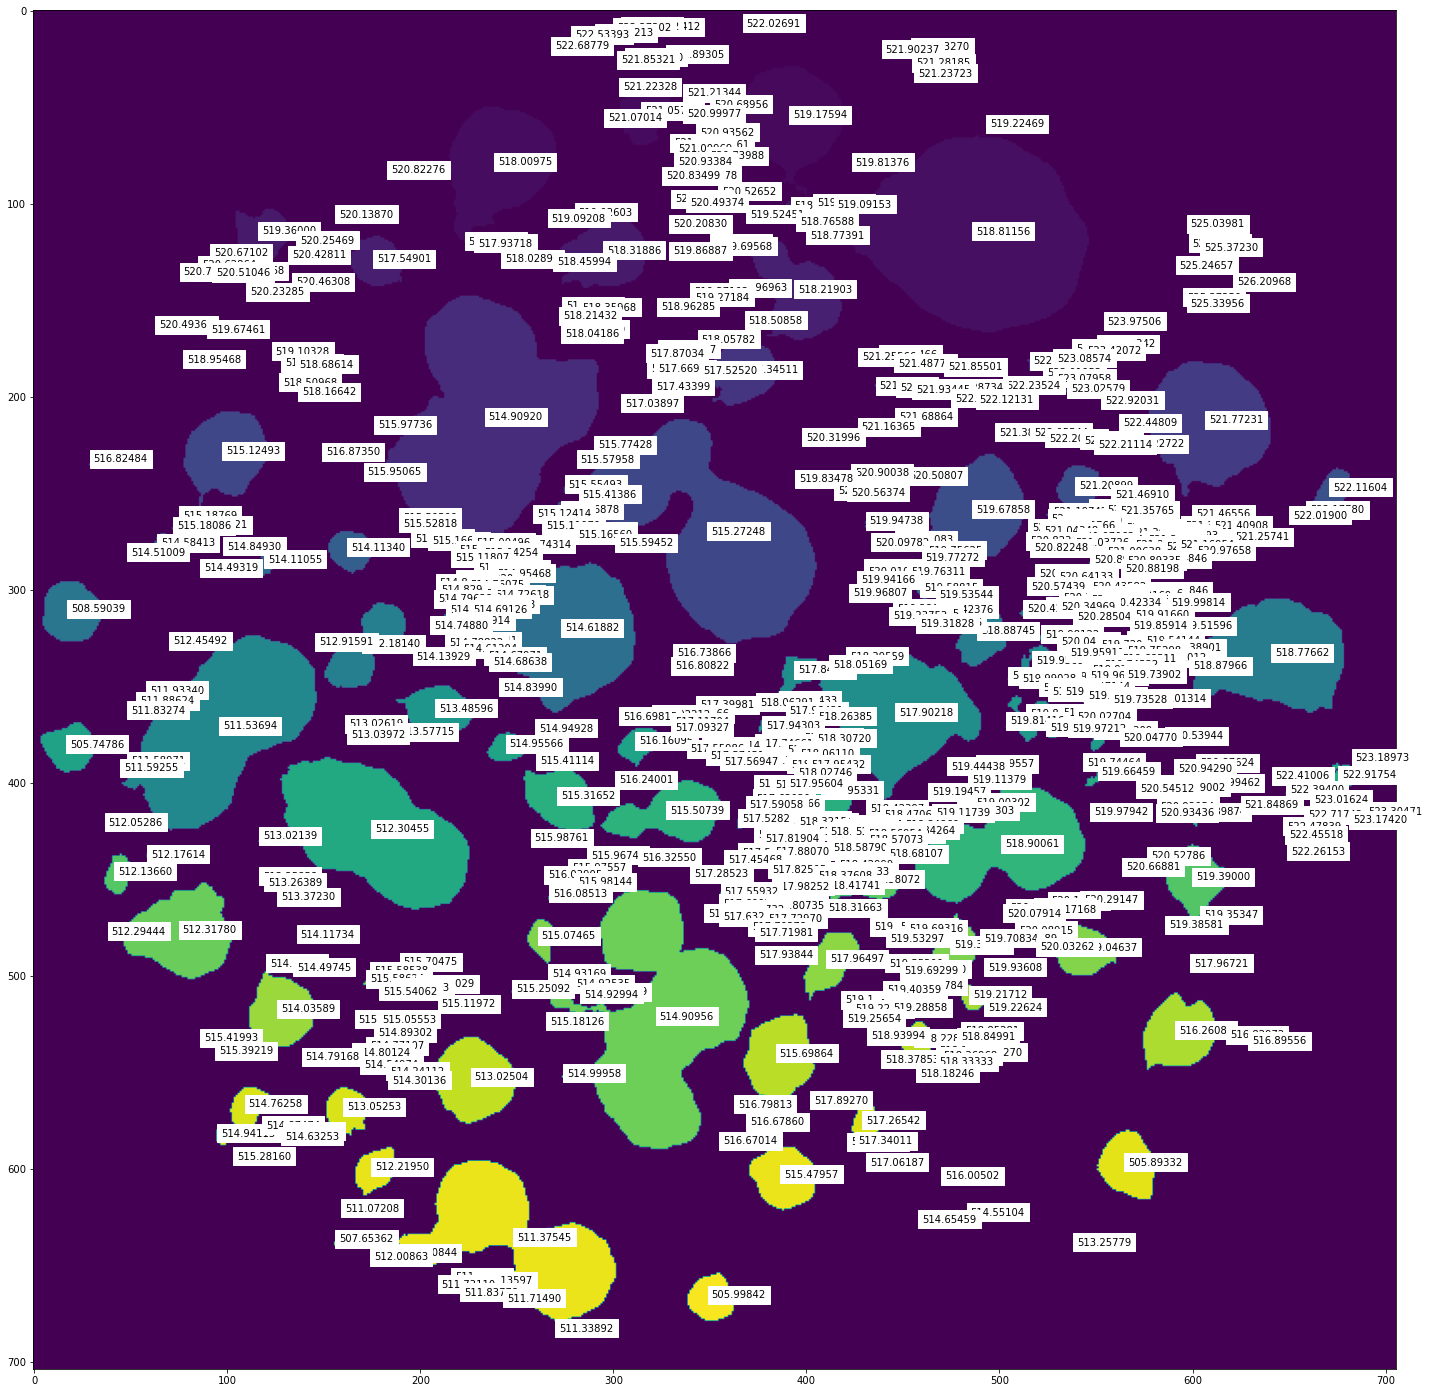

In [33]:
t_minima_labels, t_number_of_minima = skimage.morphology.label(test_mins_after_0, return_num=True)
fig, ax = plt.subplots(1, 1, figsize = (25, 25))
ax.imshow(t_minima_labels)
props = skimage.measure.regionprops(t_minima_labels)
for hole in range(t_number_of_minima):
    cy, cx = props[hole].centroid
    #ax.text(cx, cy, str(t_minima_labels[int(cy), int(cx)]), backgroundcolor='white')
    ax.text(cx, cy, "%.5f" % test_filled_0[int(cy), int(cx)], backgroundcolor='white')

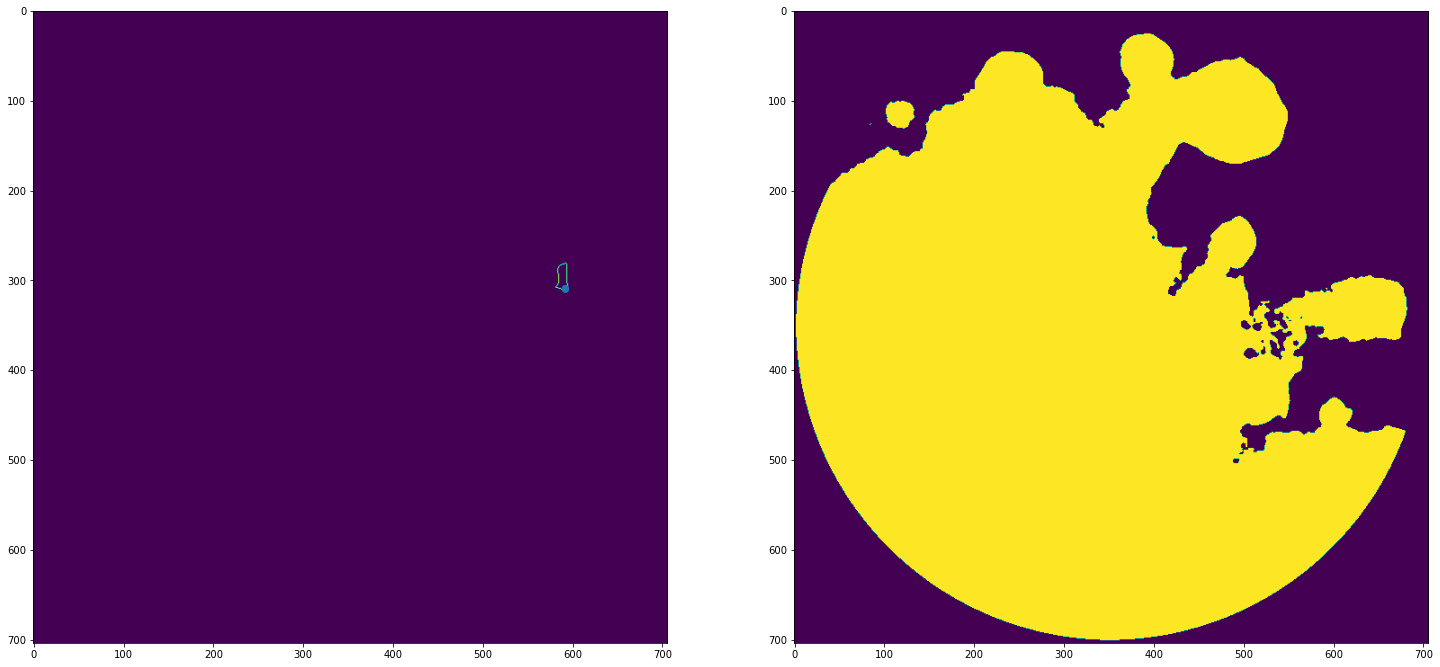

In [34]:
t_watershed_labels = skimage.segmentation.watershed(test_filled_0, t_minima_labels, mask = data_mask)
s = 250

t_local_indicator = (t_watershed_labels == s).astype(int)
t_pour_height = nonzero_min(test_filled_0, (ndimage.distance_transform_edt(t_local_indicator) < 1.3) * t_local_indicator)
t_pour_area = t_local_indicator * (test_filled_0 == t_pour_height)
tp_y, tp_x = np.array(np.where(t_pour_area))

t_bottom_height = nonzero_min(test_filled_0, t_local_indicator)
t_hole_indicator = ((test_filled_0 <= t_pour_height) * t_local_indicator).astype(int)

fig, ax = plt.subplots(1, 2, figsize = (25, 25))
ax[0].imshow((ndimage.distance_transform_edt(t_local_indicator) < 1.3) * t_local_indicator)
ax[0].scatter(tp_x, tp_y)
ax[1].imshow(test_filled_0 <= t_pour_height)

In [35]:
t_pour_height

519.994664

In [36]:
from sinkhole_util import get_window

tpt = (int(tp_y), int(tp_x))

test_extent = 30
t_filled_w, _ = get_window(test_filled_0, tpt, test_extent, normalize=False)
t_indicator_w, _ = get_window(test_sinkhole_mask_0, tpt, test_extent, normalize=False)
t_mins_w, _ = get_window(test_mins_after_0, tpt, test_extent, normalize=False)
t_water_w, _ = get_window(t_watershed_labels, tpt, test_extent, normalize=False)

TypeError: only size-1 arrays can be converted to Python scalars

NameError: name 't_water_w' is not defined

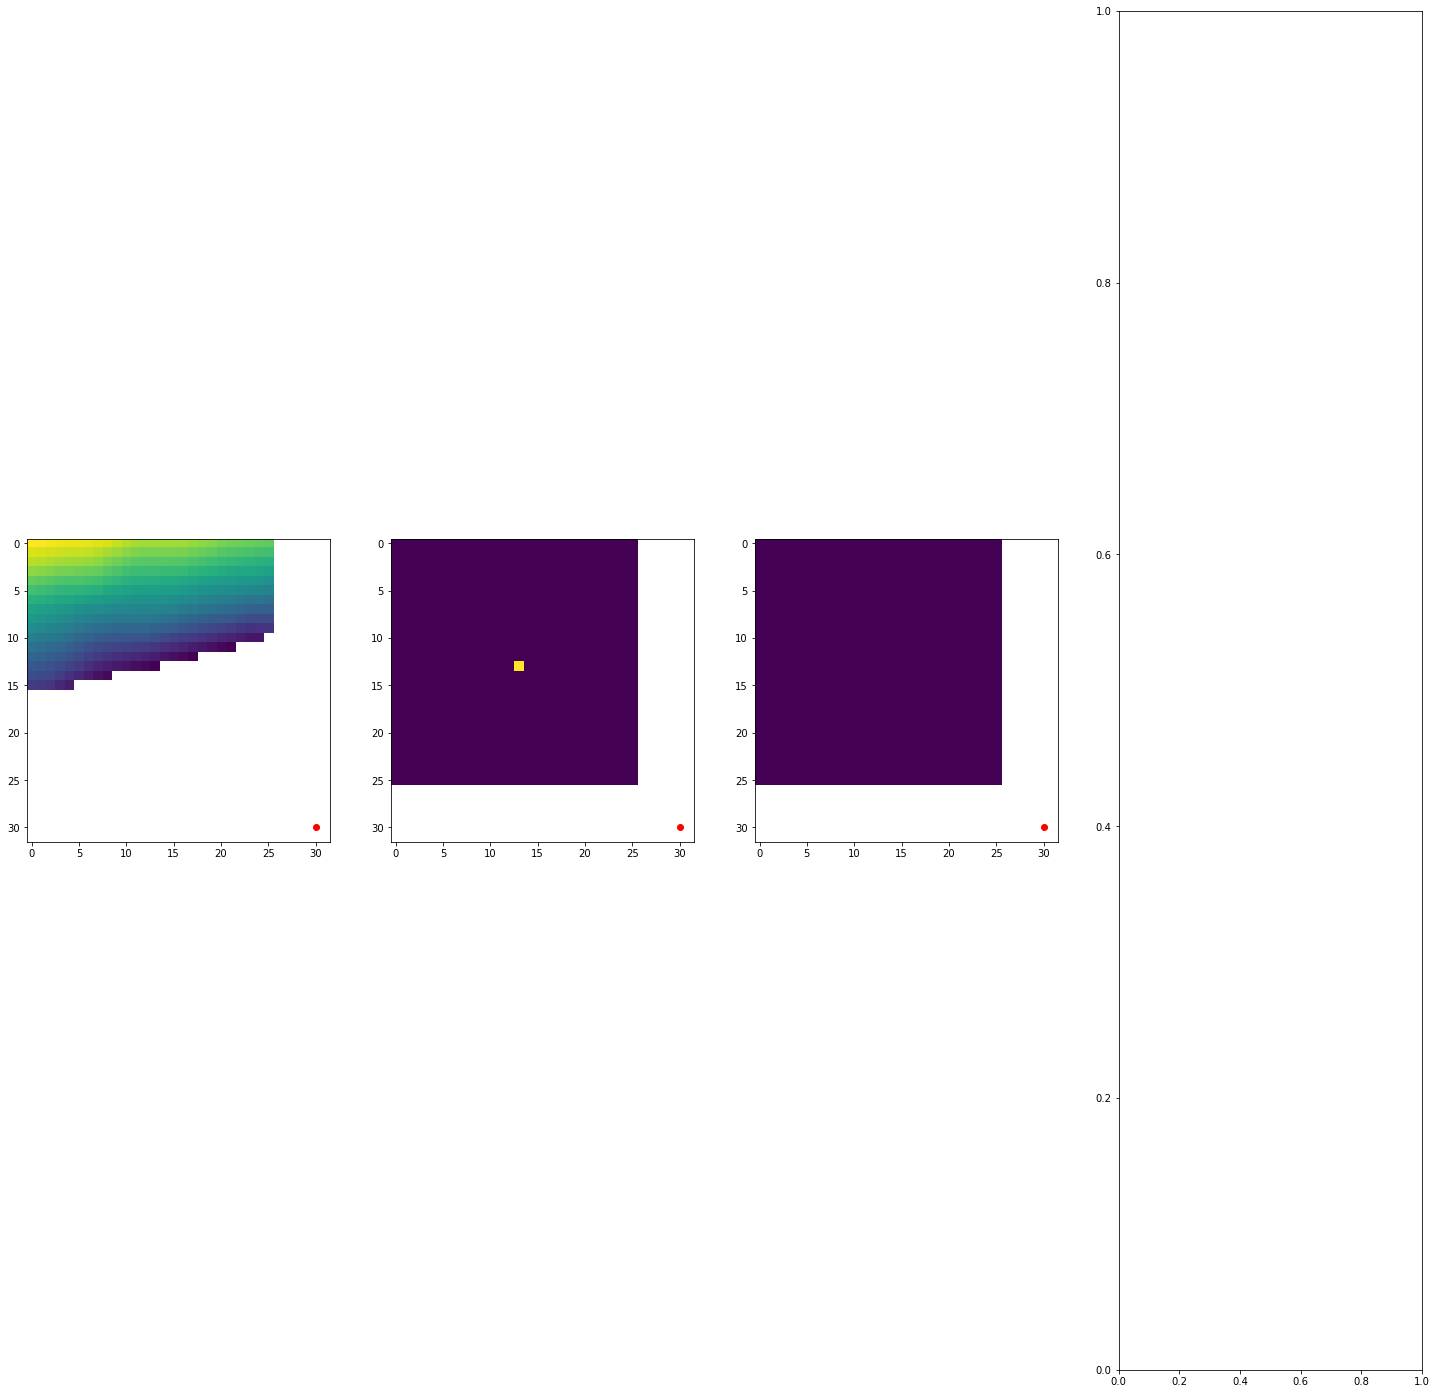

In [37]:
fig, ax = plt.subplots(1, 4, figsize = (25, 25))
ax[0].imshow(t_filled_w)
ax[0].scatter(test_extent, test_extent, color='red')
ax[1].imshow(t_indicator_w)
ax[1].scatter(test_extent, test_extent, color='red')
ax[2].imshow(t_mins_w)
ax[2].scatter(test_extent, test_extent, color='red')
ax[3].imshow(t_water_w)
ax[3].scatter(test_extent, test_extent, color='red')

In [ ]:
t_cut_height = t_filled_w[test_extent, :]

fig, ax = plt.subplots(1, 2, figsize = (10, 10))
ax[0].scatter(range(len(t_cut_height)), t_cut_height)
ax[1].scatter(range(2*4+1), t_cut_height[(test_extent-4):(test_extent+4+1)])

In [ ]:
t_cut_height[(test_extent-3):(test_extent+3+1)]

In [ ]:
from pysheds import grid

In [ ]:
grid.flowdir